In [44]:
import sys
sys.path.append('../src')
%matplotlib widget

In [45]:
import os

import numpy as np
from pynwb import NWBHDF5IO

from population_analysis.consts import NUM_FIRINGRATE_SAMPLES
from population_analysis.quantification.euclidian import EuclidianQuantification
import matplotlib.pyplot as plt


def _calc_dists(data_dict):
    # Calculate the mean euclidian distance between datasets, pairwise
    # data_dict is {"Rp(Extra)": <rp data>, ..}
    # returns like {"Rp(Extra)-Rp(Peri)": [dist_t_0, dist_t_1, ..], ..}
    euclid_dist = EuclidianQuantification("Pairwise")

    def dist_func(name, data, name1, data1):
        dist_data = []
        dist_name = f"{name}-{name1}"

        for t in range(NUM_FIRINGRATE_SAMPLES):
            dist_data.append(euclid_dist.calculate(
                data[:, :, t].swapaxes(0, 1),
                data1[:, :, t].swapaxes(0, 1)
            ))
        return dist_name, dist_data
    result = _pairwise_iter(data_dict, dist_func)
    d = {}
    for k, v in result:
        d[k] = v
    return d


def _pairwise_iter(data_dict, func):
    # func is f(name, data, name2, data2) -> result: Any
    results = []
    data_pairs = list(data_dict.items())
    for i in range(len(data_pairs)):
        name, data = data_pairs.pop()
        for name1, data1 in data_pairs:
            if name == name1:
                continue
            results.append(func(name, data, name1, data1))
    return results


In [46]:
filename = "2023-05-15_mlati7_output"
filepath = "../scripts/" + filename + ".nwb"
filename_prefix = f"../graphs/{filename}"
if not os.path.exists(filename_prefix):
    os.makedirs(filename_prefix)

nwbio = NWBHDF5IO(filepath)
nwb = nwbio.read()

probe_trial_idxs = nwb.processing["behavior"]["unit-trial-probe"].data[:]
saccade_trial_idxs = nwb.processing["behavior"]["unit-trial-saccade"].data[:]
mixed_trial_idxs = nwb.processing["behavior"]["unit-trial-mixed"].data[:]

# Filter out mixed trials that saccades are more than 20ms away from the probe
mixed_rel_timestamps = nwb.processing["behavior"]["mixed-trial-saccade-relative-timestamps"].data[:]
mixed_filtered_idxs = np.abs(mixed_rel_timestamps) <= 0.02  # 20 ms
mixed_trial_idxs = mixed_trial_idxs[mixed_filtered_idxs]

# (units, trials, t)
probe_units = nwb.units["trial_response_firing_rates"].data[:, probe_trial_idxs]
saccade_units = nwb.units["trial_response_firing_rates"].data[:, saccade_trial_idxs]
mixed_units = nwb.units["trial_response_firing_rates"].data[:, mixed_trial_idxs]
rp_peri_units = nwb.units["r_p_peri_trials"].data[:]
tw = 2

data_dict = {
        "Rp(Extra)": probe_units,  # (units, trials, t)
        "Rs": saccade_units,
        "Rmixed": mixed_units,
        "Rp(Peri)": rp_peri_units
    }

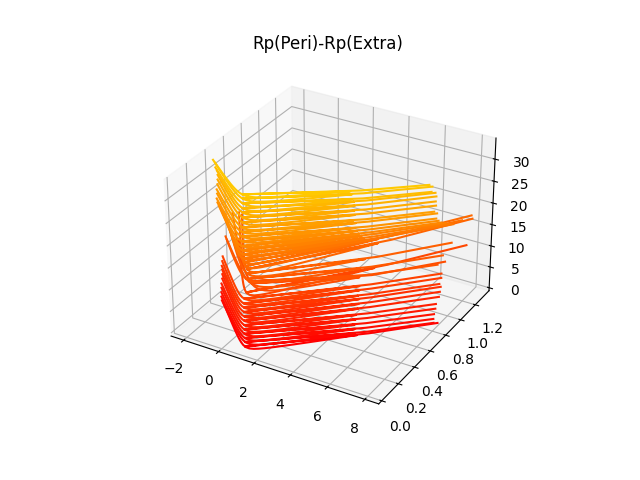

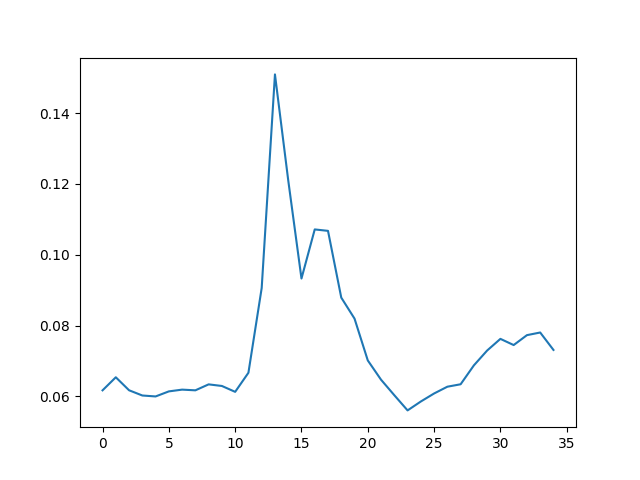

In [55]:
# iterate over a space of scales to determine distance between means
no_change_idx = 36
scale_range = np.linspace(-2, 8)
scale_range[no_change_idx] = 1

def wrapper(timepoint):
    def iter_func(name1, data1, name2, data2):
        data1_mean = np.mean(data1, axis=1)[:, timepoint]  # (units, t) avg trials out
        data2_mean = np.mean(data2, axis=1)[:, timepoint]

        data1_mean = scale_range[:, None] * np.broadcast_to(data1_mean, (len(scale_range), *data1_mean.shape))
        data2_mean = np.broadcast_to(data2_mean, (len(scale_range), *data2_mean.shape))

        euclid_dist = EuclidianQuantification("Scaled")
        dists = [euclid_dist.calculate([data1_mean[i, :]], [data2_mean[i, :]]) for i in range(len(scale_range))]
        return f"{name1}-{name2}", dists

        # for t in range(NUM_FIRINGRATE_SAMPLES):
        #     t1 = data1_mean[:, t]
        #     t2 = data2_mean[:, t]

        # for unit_num in range(data1_mean.shape[0]):
        #     unit1 = data1_mean[unit_num]
        #     unit2 = data2_mean[unit_num]
        #     umin = min(np.min(unit1), np.min(unit2))
        #     umax = max(np.max(unit2), np.max(unit2))
        #     scale_range = np.linspace(umin, umax)

        # dmax =
        # dmin =

    return iter_func

count = 0
name = None
# for k, v in result:
fig = plt.figure()
three_d = True
if three_d:
    ax = fig.add_subplot(projection='3d')
else:
    ax = fig.add_subplot()
all_data = []
for i in range(NUM_FIRINGRATE_SAMPLES):
    # x = scale_range
    # y = v
    # z =
    result = _pairwise_iter(data_dict, wrapper(i))
    k, v = result[0]
    name = k
    all_data.append(v)
    args = [scale_range[range(len(v))], v]
    if three_d:
        args.append(count)

    ax.plot(*args, color=plt.get_cmap("hsv")(count))
    count = count + 1
plt.title(name)
plt.show()

y = np.array(all_data)[:, no_change_idx]
plt.figure()
plt.plot(range(len(y)), y)
plt.show()
tw = 2

In [52]:
all_data = np.array(all_data)

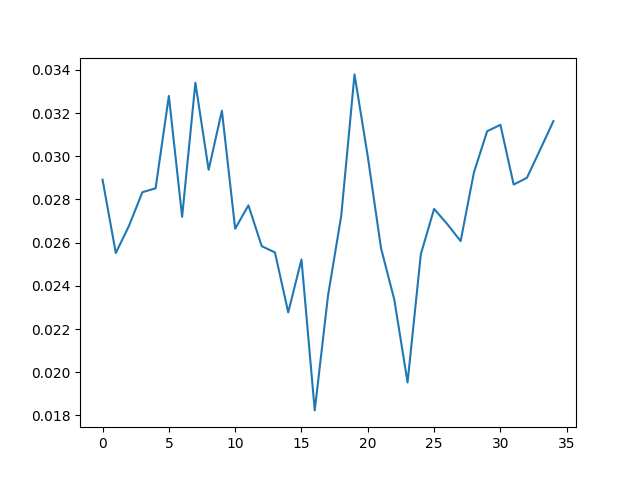

In [53]:
y = all_data[:, no_change_idx]
plt.clf()
plt.figure()
plt.plot(range(len(y)), y)

In [50]:
y

array([0.02891787, 0.02551968, 0.02678876, 0.02833626, 0.02851988,
       0.03279809, 0.02719514, 0.03340729, 0.02937523, 0.03211364,
       0.02664802, 0.02772939, 0.02583992, 0.02554821, 0.02277015,
       0.02521954, 0.01822921, 0.02353786, 0.02725561, 0.03379569,
       0.02998855, 0.02573997, 0.0233568 , 0.01952545, 0.02546701,
       0.02756361, 0.02685505, 0.0260712 , 0.02924529, 0.03116312,
       0.03145951, 0.02869197, 0.02900596, 0.0303121 , 0.03163528])

In [26]:
scale_range[36]

0.9387755102040813

In [43]:
nwbio.close()